In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from tqdm import tqdm

In [3]:
def load_data(img_name):
    left_path = 'stage2_project_data/stage2_stereo/left_imgs/'+img_name
    right_path = 'stage2_project_data/stage2_stereo/right_imgs/'+img_name
    disp_path = 'stage2_project_data/stage2_stereo/disparities/'+img_name
    
    left_img = cv2.imread(left_path, 0)
    right_img = cv2.imread(right_path, 0)
    
    gt_disp = cv2.imread(disp_path, 0).astype(np.float32)
    
    return left_img, right_img, gt_disp

img_names = os.listdir('stage2_project_data/stage2_stereo/disparities/')[1:] # Skips .DS_Store

In [4]:
left_img, right_img, gt_disp = load_data(img_names[0])

In [5]:
max_disparity = 16*7
block_size = 23
rmse_sum = 0
stereo = cv2.StereoBM.create(numDisparities=max_disparity, blockSize=block_size)
disparity = stereo.compute(left_img, right_img)
disparity = cv2.normalize(disparity, None, alpha=0, beta=max_disparity, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# plt.imshow(disparity,'gray')
# plt.show()

# Error
mask = np.logical_or(disparity == 0, gt_disp == 0)
masked_sq_err = np.ma.array(np.square(disparity - gt_disp), mask=mask)
rmse = np.sqrt(masked_sq_err.mean())

print(rmse)

3.573819044724706


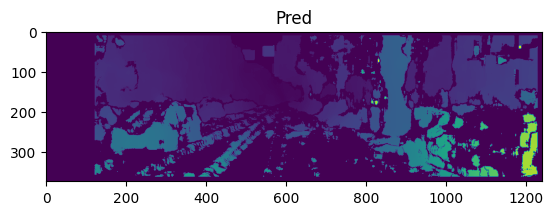

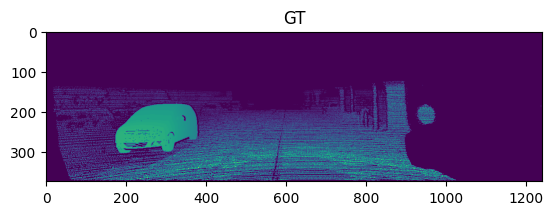

In [6]:
plt.imshow(disparity)
plt.title('Pred')
plt.show()

plt.imshow(gt_disp)
plt.title('GT')
plt.show()

In [7]:
# Find Disparity Ranges
d_max = []
for i in img_names:
    disp_path = 'stage2_project_data/stage2_stereo/disparities/'+i
    gt_disp = cv2.imread(disp_path, 0).astype(np.float32)
    d_max.append(np.max(gt_disp))
d_max

[64.0, 78.0, 66.0, 102.0, 98.0]

In [9]:
# Find Best Params and Minimum RMSE's per Image
rmse_all = []
params_all = []
disp_all = []
mask_all = []
disp_range = np.arange(16,257,16)
block_range = np.arange(5,51,2)

for img_name in tqdm(img_names):
    rmse_cur, params_cur, disp_cur, mask_cur = [],[],[],[]
    for max_disparity in disp_range:
        for block_size in block_range:
            left_img, right_img, gt_disp = load_data(img_name)

            stereo = cv2.StereoBM.create(numDisparities=max_disparity, blockSize=block_size)
            disparity = stereo.compute(left_img, right_img)
            disparity = cv2.normalize(disparity, None, alpha=0, beta=max_disparity, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

            # Error
            mask = np.logical_or(disparity == 0, gt_disp == 0)
            masked_sq_err = np.ma.array(np.square(disparity - gt_disp), mask=mask)
            rmse = np.sqrt(masked_sq_err.mean())

            rmse_cur.append(rmse)
            params_cur.append((max_disparity, block_size))
            disp_cur.append(disparity)
            mask_cur.append(mask)
            
    idx = np.argmin(rmse_cur)
    rmse_all.append(rmse_cur[idx])
    params_all.append(params_cur[idx])
    disp_all.append(disp_cur[idx])
    mask_all.append(mask_cur[idx])

print('Average RMSE: ', np.mean(rmse_all))

100%|██████████| 5/5 [01:28<00:00, 17.64s/it]

Average RMSE:  3.6837087898684615


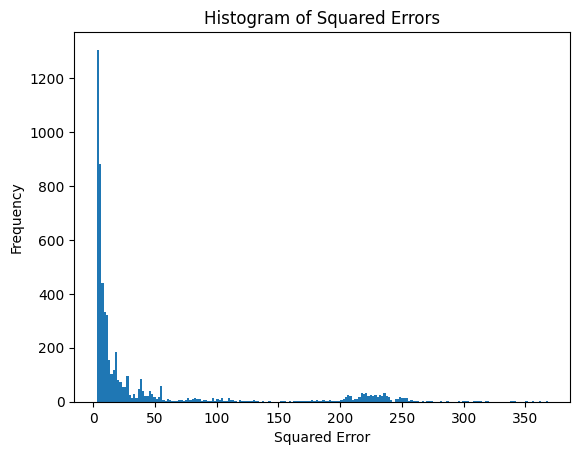

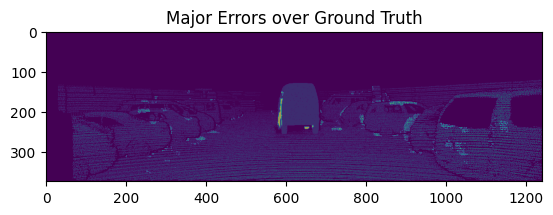

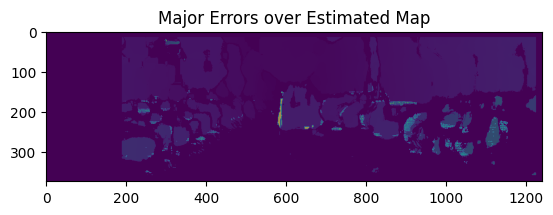

In [10]:
# Explore where errors are occuring in image 5
img_num = 4
left_img, _, gt_disp = load_data(img_names[img_num])
dist_sq = np.square((disp_all[img_num] - gt_disp) * np.invert(mask_all[img_num]))
dist_maj = dist_sq[(dist_sq>3) * (dist_sq < 500)]

plt.hist(dist_maj, bins=200)
plt.title('Histogram of Squared Errors')
plt.xlabel('Squared Error')
plt.ylabel('Frequency')
plt.show()

dist_parse = dist_sq
dist_parse[dist_parse<10]=0
dist_parse[dist_parse>300]=0
dist_parse[dist_parse > 0] = 1

plt.imshow(gt_disp)
plt.imshow(dist_parse, alpha =0.5)
plt.title('Major Errors over Ground Truth')
plt.show()

plt.imshow(disp_all[-1])
plt.imshow(dist_parse, alpha =0.5)
plt.title('Major Errors over Estimated Map')
plt.show()

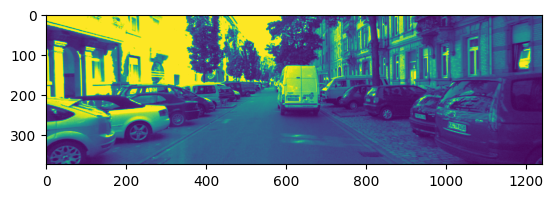

In [11]:
plt.imshow(left_img)